<a href="https://colab.research.google.com/github/matYal-Ji/fcc-health-cost-predictor/blob/main/Copy_of_fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-08-07 08:04:03--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.008s  

2021-08-07 08:04:03 (5.77 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
# 80% training data and 20% test data

size          = int(len(dataset) * .2)
train_dataset = dataset[:-size]
test_dataset  = dataset[-size:]

print(len(dataset), len(train_dataset), len(test_dataset))

1338 1071 267


In [4]:
train_labels  = train_dataset['expenses']
train_dataset = train_dataset.drop('expenses', axis=1)

test_labels   = test_dataset['expenses']
test_dataset  = test_dataset.drop('expenses', axis=1)

In [5]:
train_dataset.keys()

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [6]:
train_dataset = train_dataset.drop(['children','sex'],axis=1)
test_dataset = test_dataset.drop( ['children','sex'],axis=1)

In [7]:
labels = {}
values                  = train_dataset.smoker.astype('category')
labels['smoker']        = values.cat.categories
train_dataset['smoker'] = values.cat.codes

train_dataset.head()

,age,bmi,smoker,region
0,19,27.9,1,southwest
1,18,33.8,0,southeast
2,28,33.0,0,southeast
3,33,22.7,0,northwest
4,32,28.9,0,northwest


In [8]:
values                  = test_dataset.smoker.astype('category')
labels['smoker']        = values.cat.categories
test_dataset['smoker']  = values.cat.codes

test_dataset.head()

,age,bmi,smoker,region
1071,63,31.4,0,northeast
1072,21,31.3,0,northwest
1073,54,28.9,0,northeast
1074,60,18.3,0,northeast
1075,32,29.6,0,southeast


In [9]:
values                  = train_dataset.region.astype('category')
labels['region']        = values.cat.categories
train_dataset['region'] = values.cat.codes

train_dataset.head()

,age,bmi,smoker,region
0,19,27.9,1,3
1,18,33.8,0,2
2,28,33.0,0,2
3,33,22.7,0,1
4,32,28.9,0,1


In [10]:
values                  = test_dataset.region.astype('category')
labels['region_t']      = values.cat.categories
test_dataset['region']  = values.cat.codes

train_dataset.head()

,age,bmi,smoker,region
0,19,27.9,1,3
1,18,33.8,0,2
2,28,33.0,0,2
3,33,22.7,0,1
4,32,28.9,0,1


In [11]:
labels

{'region': Index(['northeast', 'northwest', 'southeast', 'southwest'], dtype='object'),
 'region_t': Index(['northeast', 'northwest', 'southeast', 'southwest'], dtype='object'),
 'smoker': Index(['no', 'yes'], dtype='object')}

In [12]:
train_dataset = train_dataset.drop(['region'],axis=1)
test_dataset = test_dataset.drop( ['region'],axis=1)

In [13]:
# Building Model :-

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(len(train_dataset.keys()),)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(0.05),
    loss='mse',
    metrics=['mae', 'mse']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3)                 12        
_________________________________________________________________
dense (Dense)                (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 6,477
Trainable params: 6,471
Non-trainable params: 6
_________________________________________________________________


In [14]:
model.fit(train_dataset, train_labels, epochs=20, verbose=0)

In [15]:
# Evaluating
res = model.evaluate(test_dataset, test_labels, verbose=2)
print(res)

9/9 - 0s - loss: 25681086.0000 - mae: 3177.7087 - mse: 25681086.0000
[25681086.0, 3177.708740234375, 25681086.0]


9/9 - 0s - loss: 25681086.0000 - mae: 3177.7087 - mse: 25681086.0000
Testing set Mean Abs Error: 3177.71 expenses
You passed the challenge. Great job!


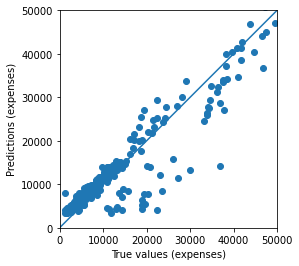

In [16]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
